|         | Moral | Immoral |
|---------|-------|---------|
| Moral   | 2,2   | 0,3     |
| Immoral | 3,0   | 1,1     |

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class individual():
    
    def __init__(self,        
                 i,          # index of individual  
                 size,       # size of population
                 mor,        # morality, probability of interacting morally
                 naiv,       # naivety, assumed utility of interactions with all individuals
                 mem):       # memory, probability of interacting with the individual with highest value
        
        self.i = i
        self.size = size
        self.mor = mor
        self.naiv = naiv
        self.mem = mem
        
        self.iter_ct = 1     # number of interactions this individual has had
                             # set to 1 as self.naiv counts as 1 interaction
        self.tot_util = 0    # sum of utility of all interactions so far
        self.pop_vals = [self.naiv for i in range(self.size)] # list of estimated utility of iteractions with all individuals
    
    # choose an individual to interact with
        # with probability self.mem, choose the individual with the highest utility in pop_vals
        # with probablity 1-self.mem, choose a random individual
    def choose_ind(self):
        if random.uniform(0,1) < self.mem:
            max_val = max(self.pop_vals)
            max_vals = [ind_i for ind_i,ind_util in enumerate(self.pop_vals) if ind_util is max_val]
            return random.choice(max_vals)
        else:
            return self.pop_vals.index(random.choice(self.pop_vals))
    
    # choose whether to interact morally or not
        # with probability self.mor, interact morally
        # with probability 1-self.mor, interact imorally
    def mor_or_imor(self):
        if random.uniform(0, 1) < self.mor:
            return 0
        else:
            return 1
    
    # update the utility of the individual in pop_vals after each interaction
        # the updated value is the average of the values of all interactions with the individual and self.naiv
    def update_vals(self, ind_i, util):
        avg_util = self.pop_vals[ind_i]
        avg_util = avg_util + (util-avg_util)/self.iter_ct
        self.pop_vals[ind_i] = avg_util
    
    # update the total utility after each interaction
        # by adding the utility of the interaction to self.tot_util
    def update_util(self, util):
        self.tot_util += util

In [3]:
class population():
    
    def __init__(self, size, mors, naivs, mems, mut, max_inters):
        
        self.size = size
        self.mors = mors   # list of morality values, one for each individual
        self.naivs = naivs # list of naivety values
        self.mems = mems   # list of memory values
        self.mut = mut     # list of mutation values
                                # in the form of [morality_mutation, naivety_mutation, memory_mutation]
        
        self.max_inters = max_inters
        self.inds = []
        
        # create self.size individuals
        for i in range(self.size):
            
            sz = self.size
            mor = self.mors[i]
            naiv = self.naivs[i]
            mem = self.mems[i]
            
            new_ind = individual(i, sz, mor, naiv, mem)
            self.inds.append(new_ind)
            
    # Outputs the utility of the interaction for both individuals
        # Given the choices of both individuals as a list, such as [0, 1]
            # 0 is choosing to interact morally
            # 1 is choosing to interact immorally
        # outpus the payoffs of both individuals as a list, such as [3,0]
    def matrix(self, choice_1, choice_2):
        if choice_1 is 0:
            if choice_2 is 0:
                return [2,2]
            else:
                return [0,3]
        else:
            if choice_2 is 0:
                return [3,0]
            else:
                return [1,1]
    
    # given an individual, let it interact self.max_inter times with individuals of his choosing
        # and update the tot_util and pop_vals of all individuals involved
    def one_inter(self, ind_a_i):
        
        ind_a = self.inds[ind_a_i]
        ind_b_i = ind_a.choose_ind()
        ind_b = self.inds[ind_b_i]
        
        ind_a.iter_ct += 1
        ind_b.iter_ct += 1
        
        a_choice = ind_a.mor_or_imor()
        b_choice = ind_b.mor_or_imor()
        
        payoffs = self.matrix(a_choice, b_choice)
        
        ind_a.update_vals(ind_b_i, payoffs[0])
        ind_b.update_vals(ind_a_i, payoffs[1])
        
        ind_a.update_util(payoffs[0])
        ind_b.update_util(payoffs[1])
    
    # let each individual in the population to interact self.max_inters times
    def pop_inter(self):
        for i in range(self.size):
            for j in range(self.max_inters):
                self.one_inter(i)
    
    # output mutation
        # given self.mut, say [0.2, 0.5, 0.2]
        # outputs three random float from -0.2 to 0.2, -0.5 to 0.5, -0.2 to 0.2
    def mutation(self):
        mor_mut = random.uniform(-self.mut[0], self.mut[0])
        naiv_mut = random.uniform(-self.mut[1], self.mut[1])
        mem_mut = random.uniform(-self.mut[1], self.mut[1])
        return mor_mut, naiv_mut, mem_mut
    
    # outputs the next generation's lists of morality, naivety, and memory
    def next_gen(self):
        
        lottery = []
        new_mors = []
        new_naivs = []
        new_mems = []
        
        for i in range(self.size):
            for j in range(round(self.inds[i].tot_util/50)):
                lottery.append(i)
    
        for i in range(self.size):
            parent_a = random.choice(lottery)
            parent_b = random.choice(lottery)
            
            mor_mut, naiv_mut, mem_mut = self.mutation()
            
            new_mor = min(max((self.inds[parent_a].mor + self.inds[parent_b].mor)/2 + mor_mut, 0),1)
            new_naiv = min(max((self.inds[parent_a].naiv + self.inds[parent_b].naiv)/2 + naiv_mut, 0),3)
            new_mem = min(max((self.inds[parent_a].mem + self.inds[parent_b].mem)/2 + mem_mut, 0),1)
            
            new_mors.append(new_mor)
            new_naivs.append(new_naiv)
            new_mems.append(new_mem)
            
        return new_mors, new_naivs, new_mems
    
    # outputs utility per individual per interaction
        # analogous to GDP per capita per hour
        # indicative of overall utility of the population
    def util_per(self):
        tot_util = sum([ind.tot_util for ind in self.inds])
        tot_iters = sum([ind.iter_ct for ind in self.inds])
        return round(tot_util/tot_iters, 2)
    
    # outputs the average morality of the population
    def avg_mor(self):
        return round(np.mean([ind.mor for ind in self.inds]),2)
    
    # outputs the average naivety of the population
    def avg_naiv(self):
        return round(np.mean([ind.naiv for ind in self.inds]),2)
    
    # outputs the average memory of the population
    def avg_mem(self):
        return round(np.mean([ind.mem for ind in self.inds]),2)
    
    # return the 66th and 33rd percentile of morality of a given population
        # refer to individuals above the 66th percentile as prey
        # and those below the 33rd percentile as predators
    def pred_prey(self):
        prey = np.percentile([ind.mor for ind in self.inds], 66)
        pred = np.percentile([ind.mor for ind in self.inds], 33)
        return prey, pred
    
    # prints average morality and utility per individual per interaction
    def print_pop(self):
        avg_mor = self.avg_mor()
        avg_naiv = self.avg_naiv()
        avg_mem = self.avg_mem()
        util_per = self.util_per()
        print (str(avg_mor) + '\t' + str(avg_naiv) + '\t' + str(avg_mem) + '\t' + str(util_per))
        return avg_mor, avg_naiv, avg_mem, util_per

In [4]:
class evolution():
    
    def __init__(self, size, mut, max_inters):
        
        self.size = size
        self.mut = mut
        self.max_inters = max_inters
        self.cur_pop = None
        
        # initial population has random morality, naivety, and memory
        rand_mor = [random.uniform(0,1) for i in range(self.size)]
        rand_naiv = [random.uniform(0,3) for i in range(self.size)]
        rand_mem = [random.uniform(0,1) for i in range(self.size)]
        init_pop = population(self.size, rand_mor, rand_naiv, rand_mem , self.mut, self.max_inters)
        self.cur_pop = init_pop
    
    # outputs the next generation
    def evolve_one(self):
        self.cur_pop.pop_inter()
        new_mors, new_naivs, new_mems = self.cur_pop.next_gen()
        self.cur_pop = population(self.size, new_mors, new_naivs, new_mems, self.mut, self.max_inters)
        return self.cur_pop
    
    # evolve over a given number of generations
        # gens is the number of generations to evolve
        # graph is a boolean value of whether to graph the evolution
            # the lines in the graph are
                # average morality
                # average prey morality
                # average predator morality
                # average naivety
                # average memory
                # average utility per individual per interaction
    def evolve_gens(self, gens, graph):
        
        xs = []
        avg_mors = []
        avg_naivs = []
        avg_mems = []
        avg_utils = []
        prey_mors = []
        pred_mors = []
        
        for i in range(gens):
            
            self.cur_pop.pop_inter()
            avg_mor, avg_naiv, avg_mem, util_per = self.cur_pop.print_pop()
            prey_mor, pred_mor = self.cur_pop.pred_prey()
            self.evolve_one()
            
            xs.append(i)
            avg_mors.append(avg_mor)
            avg_naivs.append(avg_naiv)
            avg_mems.append(avg_mem)
            avg_utils.append(util_per)
            prey_mors.append(prey_mor)
            pred_mors.append(pred_mor)
            
        if graph:
            
            tt = 'mor_mut: ' + str(self.mut[0]) + ', naiv_mut: ' + str(self.mut[1]) + ', mem_mut: ' + str(self.mut[2])
            plt.title(tt)
            plt.xlabel('Generations')
            
            plt.plot(xs,avg_mors, label='avg_mor')
            plt.plot(xs,prey_mors, label='prey_mor')
            plt.plot(xs,pred_mors, label='pred_mor')
            plt.plot(xs,avg_naivs, label='avg_naiv')
            plt.plot(xs,avg_mems, label='avg_mem')
            plt.plot(xs,avg_utils, label='util_per')
            
            plt.legend(loc='upper left') #, frameon=False
            plt.grid(linestyle='dotted')
            plt.savefig(tt+'.png', dpi=1200)
            plt.show()

0.54	1.45	0.57	1.58
0.56	1.44	0.59	1.63
0.57	1.49	0.65	1.59
0.61	1.6	0.62	1.64
0.64	1.74	0.62	1.67
0.68	1.78	0.61	1.69
0.69	1.8	0.62	1.7
0.69	1.9	0.65	1.68
0.69	1.93	0.65	1.7
0.71	1.92	0.64	1.72
0.74	1.96	0.64	1.74
0.76	1.98	0.61	1.76
0.79	2.0	0.55	1.79
0.78	2.02	0.59	1.79
0.79	1.99	0.57	1.79
0.79	1.93	0.58	1.79
0.8	1.95	0.54	1.81
0.82	1.93	0.55	1.82
0.82	1.92	0.49	1.82
0.82	1.93	0.42	1.83
0.83	1.93	0.46	1.83
0.82	1.92	0.51	1.83
0.85	2.04	0.57	1.85
0.86	1.98	0.52	1.87
0.87	2.09	0.52	1.87
0.89	2.08	0.53	1.89
0.91	2.11	0.53	1.9
0.9	2.12	0.53	1.9
0.9	2.2	0.57	1.89
0.9	2.14	0.52	1.89
0.9	2.13	0.5	1.89
0.9	2.18	0.54	1.89
0.9	2.19	0.55	1.9
0.91	2.21	0.53	1.9
0.91	2.16	0.6	1.91
0.91	2.21	0.6	1.9
0.91	2.15	0.6	1.9
0.91	2.18	0.56	1.91
0.91	2.26	0.59	1.9
0.9	2.25	0.55	1.9
0.89	2.23	0.61	1.89
0.9	2.19	0.57	1.9
0.91	2.24	0.52	1.91
0.9	2.22	0.52	1.9
0.9	2.21	0.51	1.9
0.89	2.2	0.5	1.89
0.9	2.21	0.48	1.89
0.89	2.11	0.49	1.88
0.88	2.07	0.48	1.87
0.89	2.08	0.47	1.89
0.88	2.11	0.54	1.88
0.88	2.16	0.52	1

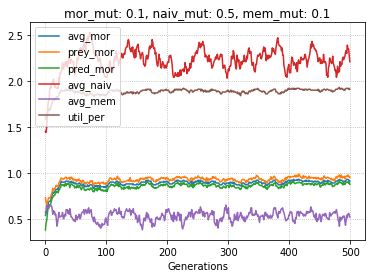

0.5	1.64	0.51	1.53
0.46	1.72	0.56	1.54
0.48	1.85	0.57	1.53
0.5	1.85	0.59	1.52
0.53	1.91	0.6	1.55
0.56	1.98	0.6	1.57
0.56	1.95	0.55	1.57
0.58	2.0	0.55	1.58
0.58	2.02	0.51	1.58
0.6	2.05	0.53	1.6
0.59	2.03	0.54	1.59
0.61	2.02	0.52	1.61
0.62	1.99	0.56	1.62
0.63	1.97	0.55	1.63
0.62	2.01	0.54	1.62
0.62	2.04	0.57	1.63
0.63	2.13	0.57	1.63
0.64	2.18	0.57	1.63
0.63	2.17	0.55	1.63
0.62	2.19	0.56	1.63
0.64	2.16	0.56	1.64
0.66	2.21	0.57	1.66
0.65	2.23	0.6	1.65
0.67	2.27	0.6	1.68
0.68	2.25	0.63	1.68
0.69	2.26	0.58	1.68
0.7	2.29	0.58	1.7
0.7	2.32	0.6	1.7
0.71	2.36	0.58	1.71
0.71	2.38	0.57	1.71
0.71	2.36	0.58	1.71
0.71	2.32	0.51	1.71
0.72	2.4	0.5	1.72
0.72	2.41	0.53	1.72
0.72	2.46	0.51	1.71
0.69	2.36	0.51	1.69
0.7	2.39	0.55	1.69
0.7	2.36	0.52	1.7
0.71	2.36	0.61	1.71
0.72	2.32	0.55	1.72
0.73	2.37	0.54	1.74
0.71	2.38	0.49	1.7
0.73	2.3	0.49	1.73
0.74	2.31	0.52	1.73
0.73	2.33	0.48	1.72
0.73	2.36	0.5	1.73
0.74	2.32	0.56	1.74
0.74	2.24	0.57	1.74
0.75	2.25	0.67	1.75
0.76	2.27	0.6	1.76
0.78	2.31	0.63	1.78
0.7

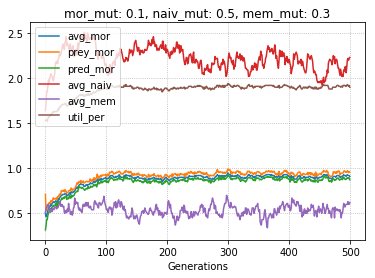

0.46	1.54	0.53	1.54
0.46	1.7	0.59	1.55
0.54	1.72	0.58	1.59
0.55	1.8	0.56	1.58
0.55	2.01	0.62	1.56
0.55	1.95	0.57	1.57
0.57	2.03	0.55	1.58
0.59	2.14	0.51	1.59
0.58	2.1	0.6	1.57
0.6	2.16	0.61	1.6
0.6	2.19	0.64	1.59
0.61	2.16	0.64	1.61
0.62	2.1	0.67	1.62
0.62	2.05	0.65	1.63
0.63	2.06	0.63	1.63
0.64	2.01	0.64	1.64
0.65	2.02	0.65	1.65
0.66	2.05	0.62	1.65
0.66	2.07	0.6	1.67
0.66	2.12	0.56	1.66
0.68	2.06	0.6	1.69
0.69	2.13	0.66	1.69
0.7	2.2	0.65	1.7
0.68	2.19	0.63	1.68
0.68	2.23	0.66	1.68
0.69	2.26	0.71	1.69
0.7	2.22	0.64	1.7
0.69	2.21	0.64	1.7
0.7	2.2	0.64	1.69
0.71	2.14	0.57	1.72
0.71	2.17	0.57	1.72
0.74	2.23	0.53	1.74
0.74	2.21	0.52	1.73
0.74	2.29	0.53	1.74
0.74	2.25	0.51	1.74
0.74	2.33	0.49	1.75
0.75	2.37	0.52	1.75
0.75	2.39	0.47	1.75
0.75	2.38	0.48	1.76
0.78	2.31	0.54	1.77
0.78	2.32	0.58	1.78
0.79	2.31	0.56	1.79
0.79	2.33	0.55	1.79
0.8	2.33	0.55	1.8
0.81	2.36	0.59	1.81
0.81	2.32	0.57	1.81
0.81	2.22	0.63	1.83
0.83	2.23	0.52	1.83
0.85	2.23	0.56	1.84
0.86	2.24	0.52	1.86
0.86	2.22	0.52	1.86


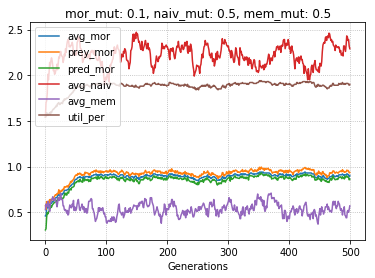

0.51	1.53	0.47	1.55
0.53	1.54	0.5	1.56
0.54	1.42	0.6	1.57
0.56	1.42	0.53	1.57
0.56	1.5	0.46	1.56
0.56	1.45	0.55	1.56
0.59	1.65	0.58	1.59
0.6	1.72	0.56	1.6
0.6	1.76	0.47	1.6
0.62	1.79	0.4	1.62
0.63	1.65	0.41	1.63
0.63	1.73	0.42	1.65
0.64	1.82	0.43	1.64
0.64	1.75	0.44	1.63
0.64	1.76	0.5	1.64
0.64	1.74	0.54	1.64
0.66	1.66	0.45	1.65
0.66	1.59	0.54	1.66
0.65	1.49	0.52	1.65
0.64	1.49	0.45	1.63
0.64	1.51	0.5	1.64
0.65	1.6	0.38	1.64
0.66	1.62	0.5	1.66
0.67	1.89	0.56	1.67
0.68	1.84	0.54	1.68
0.68	1.83	0.58	1.68
0.7	1.92	0.62	1.69
0.7	1.92	0.58	1.7
0.7	2.05	0.56	1.7
0.69	2.09	0.55	1.69
0.69	2.11	0.61	1.69
0.7	2.04	0.59	1.71
0.71	2.0	0.54	1.71
0.71	2.02	0.57	1.71
0.71	2.1	0.58	1.71
0.72	2.01	0.57	1.71
0.73	2.04	0.5	1.73
0.74	1.91	0.47	1.74
0.76	1.72	0.46	1.75
0.76	1.73	0.52	1.75
0.77	1.77	0.44	1.76
0.76	1.74	0.5	1.76
0.76	1.86	0.57	1.76
0.76	1.83	0.53	1.76
0.79	1.95	0.48	1.78
0.79	1.94	0.5	1.79
0.78	1.94	0.52	1.79
0.79	1.96	0.53	1.78
0.78	2.06	0.52	1.78
0.79	2.08	0.51	1.78
0.78	2.14	0.5	1.78
0.78

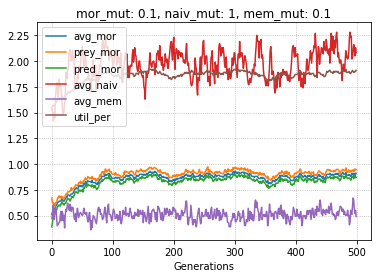

0.46	1.51	0.56	1.55
0.51	1.65	0.52	1.59
0.54	1.86	0.56	1.56
0.57	1.82	0.51	1.58
0.57	1.93	0.48	1.57
0.59	2.04	0.5	1.6
0.62	2.06	0.51	1.62
0.62	2.06	0.51	1.63
0.63	1.98	0.47	1.63
0.63	1.97	0.48	1.65
0.65	1.98	0.46	1.65
0.66	1.96	0.47	1.67
0.66	1.91	0.53	1.67
0.67	1.93	0.57	1.66
0.67	2.0	0.55	1.67
0.68	1.87	0.44	1.68
0.68	1.92	0.56	1.68
0.68	1.8	0.47	1.69
0.69	1.84	0.51	1.68
0.7	1.68	0.57	1.7
0.73	1.75	0.51	1.73
0.73	1.78	0.5	1.73
0.74	1.72	0.5	1.75
0.74	1.85	0.55	1.74
0.74	1.8	0.5	1.74
0.75	1.77	0.55	1.74
0.75	1.82	0.54	1.74
0.75	1.93	0.55	1.75
0.76	1.88	0.5	1.76
0.77	1.72	0.5	1.76
0.77	1.72	0.44	1.77
0.76	1.77	0.4	1.76
0.76	1.89	0.38	1.76
0.75	1.67	0.46	1.75
0.76	1.72	0.37	1.75
0.75	1.76	0.51	1.78
0.78	1.84	0.54	1.77
0.79	1.99	0.51	1.78
0.79	1.9	0.57	1.77
0.77	1.87	0.54	1.79
0.79	1.89	0.55	1.78
0.79	1.87	0.53	1.79
0.8	1.88	0.62	1.8
0.81	1.91	0.54	1.81
0.81	1.94	0.56	1.8
0.82	1.98	0.56	1.81
0.82	1.92	0.56	1.82
0.83	1.93	0.55	1.82
0.85	1.96	0.5	1.84
0.84	2.08	0.47	1.85
0.84	2.18	0.49	1.8

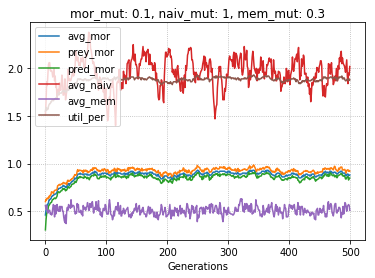

0.55	1.33	0.5	1.58
0.56	1.44	0.5	1.59
0.58	1.52	0.52	1.6
0.61	1.58	0.55	1.61
0.61	1.63	0.53	1.62
0.63	1.59	0.61	1.64
0.65	1.8	0.64	1.67
0.67	1.78	0.56	1.67
0.67	1.66	0.51	1.66
0.66	1.63	0.47	1.67
0.67	1.67	0.48	1.67
0.68	1.62	0.53	1.68
0.69	1.51	0.43	1.69
0.7	1.62	0.44	1.7
0.7	1.74	0.42	1.69
0.71	1.8	0.52	1.71
0.72	1.84	0.46	1.71
0.72	1.82	0.55	1.72
0.74	1.75	0.51	1.73
0.74	1.71	0.5	1.74
0.76	1.9	0.5	1.76
0.77	1.94	0.47	1.77
0.76	1.84	0.46	1.76
0.78	1.73	0.47	1.77
0.78	1.72	0.45	1.78
0.78	1.75	0.52	1.79
0.79	1.85	0.46	1.79
0.81	1.9	0.48	1.8
0.81	1.95	0.42	1.81
0.81	1.83	0.52	1.8
0.82	1.94	0.57	1.83
0.82	1.92	0.59	1.83
0.84	1.79	0.54	1.84
0.84	1.84	0.47	1.83
0.84	1.92	0.46	1.83
0.85	1.89	0.46	1.84
0.85	1.83	0.49	1.85
0.87	1.79	0.51	1.85
0.86	1.83	0.56	1.87
0.87	1.81	0.57	1.86
0.86	1.73	0.55	1.87
0.88	1.91	0.54	1.88
0.88	1.86	0.6	1.88
0.89	1.85	0.52	1.88
0.89	1.74	0.56	1.9
0.9	1.88	0.51	1.89
0.9	1.83	0.46	1.89
0.91	1.86	0.42	1.9
0.91	1.89	0.41	1.9
0.91	1.85	0.45	1.9
0.91	1.78	0.46	1.91
0

In [ ]:
mor_muts = [0.1, 0.3, 0.5]
naiv_muts = [0.5, 1, 1.5]
mem_muts = [0.1, 0.3, 0.5]

for mor_mut in mor_muts:
    for naiv_mut in naiv_muts:
        for mem_mut in mem_muts:
            e = evolution(100,                            # size
                          [mor_mut, naiv_mut, mem_mut],   # mutation
                          100)                            # max_inters
            e.evolve_gens(500,   # generations
                          True)  # graph